# Big Data Platforms

## Yelp Final Project

### Feature Selection
###  Casey Ellis


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_extract, create_map, lit

from pyspark.ml.feature import PCA, VectorAssembler, ChiSqSelector
from pyspark.ml.linalg import Vectors
from itertools import chain

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [2]:
#create Spark session
spark = SparkSession.builder.appName('YelpReviews').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/hive/*'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.executor.memory', '5g'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '/opt/cloudera/parcels/CDH/lib/spark/python/lib/py4j-0.10.7-src.zip:/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/pyspark.zip'),

In [3]:
!hdfs dfs -ls /user/kfgbah/Yelp/

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 5 items
-rw-r--r--   3 kfgbah kfgbah  124380583 2021-07-28 12:53 /user/kfgbah/Yelp/yelp_academic_dataset_business.json
-rw-r--r--   3 kfgbah kfgbah  398272056 2021-07-28 12:50 /user/kfgbah/Yelp/yelp_academic_dataset_checkin.json
-rw-r--r--   3 kfgbah kfgbah 6936678061 2021-07-28 12:55 /user/kfgbah/Yelp/yelp_academic_dataset_review.json
-rw-r--r--   3 kfgbah kfgbah  230307244 2021-07-28 12:52 /user/kfgbah/Yelp/yelp_academic_dataset_tip.json
-rw-r--r--   3 kfgbah kfgbah 3684505303 2021-07-28 13:05 /user/kfgbah/Yelp/yelp_academic_dataset_user.json


### Import Data
Getting the review and business data

In [4]:
%time df_rev = spark.read.json("/user/kfgbah/Yelp/yelp_academic_dataset_review.json")

CPU times: user 4.75 ms, sys: 4.55 ms, total: 9.3 ms
Wall time: 19.9 s


In [5]:
df_rev.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [6]:
df_rev.select('useful').distinct().show()

+------+
|useful|
+------+
|    26|
|    29|
|    65|
|   191|
|   222|
|    19|
|    54|
|     0|
|   167|
|   112|
|   113|
|   155|
|    22|
|   198|
|   130|
|   196|
|     7|
|    77|
|    34|
|   184|
+------+
only showing top 20 rows



In [7]:
df_rev.head(1)

[Row(business_id='buF9druCkbuXLX526sGELQ', cool=1, date='2014-10-11 03:34:02', funny=1, review_id='lWC-xP3rd6obsecCYsGZRg', stars=4.0, text="Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. \n\nAfter reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and gran

In [8]:
%time df_bus = spark.read.json("/user/kfgbah/Yelp/yelp_academic_dataset_business.json")

CPU times: user 2.92 ms, sys: 983 µs, total: 3.9 ms
Wall time: 1.13 s


In [9]:
df_bus.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [10]:
df_bus.head()

Row(address='921 Pearl St', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol="'beer_and_wine'", Ambience="{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}", BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin='False', BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", ByAppointmentOnly=None, Caters='True', CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed='False', DriveThru=None, GoodForDancing=None, GoodForKids=None, GoodForMeal="{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}", HairSpecializesIn=None, HappyHour='True', HasTV='True', Music=None, NoiseLevel="u'average'", Open24Hours=None, OutdoorSeating='True', RestaurantsAttire="'casual'", RestaurantsCounterServ

### Data processing
Selecting only restaurant, flattening the attribues, narrowing the criteria for what we would consider when predicting the ratings, and representing the values numerically 

In [11]:
df_bus = df_bus.where(df_bus.categories.like('%Restaurant%'))
df_bus.head()

Row(address='921 Pearl St', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol="'beer_and_wine'", Ambience="{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}", BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin='False', BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", ByAppointmentOnly=None, Caters='True', CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed='False', DriveThru=None, GoodForDancing=None, GoodForKids=None, GoodForMeal="{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}", HairSpecializesIn=None, HappyHour='True', HasTV='True', Music=None, NoiseLevel="u'average'", Open24Hours=None, OutdoorSeating='True', RestaurantsAttire="'casual'", RestaurantsCounterServ

In [12]:
df_bus_att = df_bus.select('business_id', 'stars', 'attributes.*');

For attributes that are a dictionary, I am expxloding them out so each entry has a column

In [13]:
df_bus_att=df_bus_att.withColumn("touristy", regexp_extract("Ambience", "(?<=\'touristy\': )\w+(?=(,|}))", 0))\
    .withColumn("hipster", regexp_extract("Ambience", "(?<=\'hipster\': )\w+(?=(,|}))", 0))\
    .withColumn("romantic", regexp_extract("Ambience", "(?<=\'romantic\': )\w+(?=(,|}))", 0))\
    .withColumn("divey", regexp_extract("Ambience", "(?<=\'divey\': )\w+(?=(,|}))", 0))\
    .withColumn("intimate", regexp_extract("Ambience", "(?<=\'intimate\': )\w+(?=(,|}))", 0))\
    .withColumn("trendy", regexp_extract("Ambience", "(?<=\'trendy\': )\w+(?=(,|}))", 0))\
    .withColumn("upscale", regexp_extract("Ambience", "(?<=\'upscale\': )\w+(?=(,|}))", 0))\
    .withColumn("classy", regexp_extract("Ambience", "(?<=\'classy\': )\w+(?=(,|}))", 0))\
    .withColumn("casual", regexp_extract("Ambience", "(?<=\'casual\': )\w+(?=(,|}))", 0))\

In [14]:
df_bus_att=df_bus_att.withColumn("garage", regexp_extract("BusinessParking", "(?<=\'garage\': )\w+(?=(,|}))", 0))\
    .withColumn("street", regexp_extract("BusinessParking", "(?<=\'street\': )\w+(?=(,|}))", 0))\
    .withColumn("validated", regexp_extract("BusinessParking", "(?<=\'validated\': )\w+(?=(,|}))", 0))\
    .withColumn("lot", regexp_extract("BusinessParking", "(?<=\'lot\': )\w+(?=(,|}))", 0))\
    .withColumn("valet", regexp_extract("BusinessParking", "(?<=\'valet\': )\w+(?=(,|}))", 0))

In [15]:
df_bus_att=df_bus_att.withColumn("dairy_free", regexp_extract("DietaryRestrictions", "(?<=\'dairy-free\': )\w+(?=(,|}))", 0))\
    .withColumn("gluten_free", regexp_extract("DietaryRestrictions", "(?<=\'gluten-free\': )\w+(?=(,|}))", 0))\
    .withColumn("vegan", regexp_extract("DietaryRestrictions", "(?<=\'vegan\': )\w+(?=(,|}))", 0))\
    .withColumn("kosher", regexp_extract("DietaryRestrictions", "(?<=\'kosher\': )\w+(?=(,|}))", 0))\
    .withColumn("halal", regexp_extract("DietaryRestrictions", "(?<=\'halal\': )\w+(?=(,|}))", 0))\
    .withColumn("soy_free", regexp_extract("DietaryRestrictions", "(?<=\'soy-free\': )\w+(?=(,|}))", 0))\
    .withColumn("vegetarian", regexp_extract("DietaryRestrictions", "(?<=\'vegetarian\': )\w+(?=(,|}))", 0))\

In [16]:
df_bus_att=df_bus_att.withColumn("dessert", regexp_extract("GoodForMeal", "(?<=\'dessert\': )\w+(?=(,|}))", 0))\
    .withColumn("latenight", regexp_extract("GoodForMeal", "(?<=\'latenight\': )\w+(?=(,|}))", 0))\
    .withColumn("lunch", regexp_extract("GoodForMeal", "(?<=\'lunch\': )\w+(?=(,|}))", 0))\
    .withColumn("dinner", regexp_extract("GoodForMeal", "(?<=\'dinner\': )\w+(?=(,|}))", 0))\
    .withColumn("brunch", regexp_extract("GoodForMeal", "(?<=\'brunch\': )\w+(?=(,|}))", 0))\
    .withColumn("breakfast", regexp_extract("GoodForMeal", "(?<=\'breakfast\': )\w+(?=(,|}))", 0))\

In [17]:
df_bus_att=df_bus_att.withColumn("dj", regexp_extract("Music", "(?<=\'dj\': )\w+(?=(,|}))", 0))\
    .withColumn("background_music", regexp_extract("Music", "(?<=\'background_music\': )\w+(?=(,|}))", 0))\
    .withColumn("no_music", regexp_extract("Music", "(?<=\'no_music\': )\w+(?=(,|}))", 0))\
    .withColumn("jukebox", regexp_extract("Music", "(?<=\'jukebox\': )\w+(?=(,|}))", 0))\
    .withColumn("live", regexp_extract("Music", "(?<=\'live\': )\w+(?=(,|}))", 0))\
    .withColumn("video", regexp_extract("Music", "(?<=\'video\': )\w+(?=(,|}))", 0))\
    .withColumn("karaoke", regexp_extract("Music", "(?<=\'karaoke\': )\w+(?=(,|}))", 0))\

In [18]:
df_bus_att.head()

Row(business_id='6iYb2HFDywm3zjuRg0shjw', stars=4.0, AcceptsInsurance=None, AgesAllowed=None, Alcohol="'beer_and_wine'", Ambience="{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}", BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin='False', BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", ByAppointmentOnly=None, Caters='True', CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed='False', DriveThru=None, GoodForDancing=None, GoodForKids=None, GoodForMeal="{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}", HairSpecializesIn=None, HappyHour='True', HasTV='True', Music=None, NoiseLevel="u'average'", Open24Hours=None, OutdoorSeating='True', RestaurantsAttire="'casual'", RestaurantsC

In [19]:
df_bus_att = df_bus_att.drop('AcceptsInsurance', 'HairSpecializesIn', 'Ambience','BestNights', 'BusinessParking', \
                'DietaryRestrictions', 'GoodForMeal', 'Music')
df_bus_att.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- AgesAllowed: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- BYOB: string (nullable = true)
 |-- BYOBCorkage: string (nullable = true)
 |-- BikeParking: string (nullable = true)
 |-- BusinessAcceptsBitcoin: string (nullable = true)
 |-- BusinessAcceptsCreditCards: string (nullable = true)
 |-- ByAppointmentOnly: string (nullable = true)
 |-- Caters: string (nullable = true)
 |-- CoatCheck: string (nullable = true)
 |-- Corkage: string (nullable = true)
 |-- DogsAllowed: string (nullable = true)
 |-- DriveThru: string (nullable = true)
 |-- GoodForDancing: string (nullable = true)
 |-- GoodForKids: string (nullable = true)
 |-- HappyHour: string (nullable = true)
 |-- HasTV: string (nullable = true)
 |-- NoiseLevel: string (nullable = true)
 |-- Open24Hours: string (nullable = true)
 |-- OutdoorSeating: string (nullable = true)
 |-- RestaurantsAttire: string (nullable = true)
 

For attributes with multiple values, I am using a dictionary to replace the values with ints

In [20]:
wDic={'null': None , 'no':3, 'u\'no\'':3, 'paid':1, 'u\'paid\'':1, 'free': 2, 'u\'free\'':2}
mapping_expr = create_map([lit(x) for x in chain(*wDic.items())])
df_bus_att = df_bus_att.withColumn('WifiInt', mapping_expr[df_bus_att['WiFi']])

In [21]:
smDic={'null': None , 'no':3, 'u\'no\'':3, 'outdoor':1, 'u\'outdoor\'':1, 'yes': 2, 'u\'yes\'':2}
mapping_expr = create_map([lit(x) for x in chain(*smDic.items())])
df_bus_att = df_bus_att.withColumn('SmokingInt', mapping_expr[df_bus_att['Smoking']])

In [22]:
prDic={'null': None, '1':1, '2':2, '3':3, '4':4}
mapping_expr = create_map([lit(x) for x in chain(*prDic.items())])
df_bus_att = df_bus_att.withColumn('RestaurantsPriceRange', mapping_expr[df_bus_att['RestaurantsPriceRange2']])

In [23]:
atDic={'null': None , 'casual':3, 'u\'casual\'':3, 'dressy':1, 'u\'dressy\'':1, 'formal': 2, 'u\'formal\'':2}
mapping_expr = create_map([lit(x) for x in chain(*atDic.items())])
df_bus_att = df_bus_att.withColumn('RestaurantsAttireInt', mapping_expr[df_bus_att['RestaurantsAttire']])

In [24]:
nlDic={'null': None , 'quiet':4, 'u\'quiet\'':4, 'average':1, 'u\'average\'':1,\
     'loud': 2, 'u\'loud\'':2, 'very_loud': 3, 'u\'very_loud\'':3}
mapping_expr = create_map([lit(x) for x in chain(*nlDic.items())])
df_bus_att = df_bus_att.withColumn('NoiseLevelInt', mapping_expr[df_bus_att['NoiseLevel']])

In [25]:
bycDic={'null': None , 'no':3, 'u\'no\'':3, 'yes_free':1, 'u\'yes_free\'':1, 'yes_corkage': 2, 'u\'yes_corkage\'':2}
mapping_expr = create_map([lit(x) for x in chain(*bycDic.items())])
df_bus_att = df_bus_att.withColumn('BYOBCorkInt', mapping_expr[df_bus_att['BYOBCorkage']])

In [26]:
aaDic={'null': None ,  'u\'allages\'':4,  'u\'18plus\'':1, 'u\'19plus\'':2,  'u\'21plus\'':3}
mapping_expr = create_map([lit(x) for x in chain(*aaDic.items())])
df_bus_att = df_bus_att.withColumn('AgesAllowedInt', mapping_expr[df_bus_att['AgesAllowed']])

In [27]:
aDic={'null': None , 'none':3, 'u\'none\'':3, 'beer_and_wine':1, 'u\'beer_and_wine\'':1, \
      'full_bar': 2, 'u\'full_bar\'':2}
mapping_expr = create_map([lit(x) for x in chain(*aDic.items())])
df_bus_att = df_bus_att.withColumn('alcoholInt', mapping_expr[df_bus_att['alcohol']])

In [28]:
df_bus_att = df_bus_att.drop('WiFi', 'Smoking', 'RestaurantsPriceRange2', 'RestaurantsAttire', 'NoiseLevel', 'BYOBCorkage'\
               ,'AgesAllowed', 'alcohol')
df_bus_att.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- BYOB: string (nullable = true)
 |-- BikeParking: string (nullable = true)
 |-- BusinessAcceptsBitcoin: string (nullable = true)
 |-- BusinessAcceptsCreditCards: string (nullable = true)
 |-- ByAppointmentOnly: string (nullable = true)
 |-- Caters: string (nullable = true)
 |-- CoatCheck: string (nullable = true)
 |-- Corkage: string (nullable = true)
 |-- DogsAllowed: string (nullable = true)
 |-- DriveThru: string (nullable = true)
 |-- GoodForDancing: string (nullable = true)
 |-- GoodForKids: string (nullable = true)
 |-- HappyHour: string (nullable = true)
 |-- HasTV: string (nullable = true)
 |-- Open24Hours: string (nullable = true)
 |-- OutdoorSeating: string (nullable = true)
 |-- RestaurantsCounterService: string (nullable = true)
 |-- RestaurantsDelivery: string (nullable = true)
 |-- RestaurantsGoodForGroups: string (nullable = true)
 |-- RestaurantsReservations: string (nullable = true

The last group not as Int are the True/False columns

In [29]:
tfDic={'null':None, 'False':1, 'True':2}
mapping_expr = create_map([lit(x) for x in chain(*tfDic.items())])

In [30]:
tfCols = ('BYOB', 'BikeParking', 'BusinessAcceptsBitcoin', 'BusinessAcceptsCreditCards', 'ByAppointmentOnly', \
'Caters', 'CoatCheck', 'Corkage', 'DogsAllowed',  'DriveThru', 'GoodForDancing', 'GoodForKids', 'HappyHour', 'HasTV', \
'Open24Hours', 'OutdoorSeating', 'RestaurantsCounterService', 'RestaurantsDelivery', 'RestaurantsGoodForGroups', \
'RestaurantsReservations', 'RestaurantsTableService', 'RestaurantsTakeOut', 'WheelchairAccessible', \
'touristy', 'hipster', 'romantic','divey', 'intimate', 'trendy', 'upscale', 'classy', 'casual', \
'garage', 'street', 'validated', 'lot', 'valet', 'dairy_free', 'gluten_free', 'vegan', \
'kosher', 'halal', 'soy_free', 'vegetarian', 'dessert', 'latenight', 'lunch', 'dinner', \
'brunch', 'breakfast', 'dj', 'background_music', 'no_music', 'jukebox', 'live', 'video', 'karaoke')

In [31]:
for c in tfCols:
    df_bus_att = df_bus_att.withColumn(c, mapping_expr[df_bus_att[c]])

In [32]:
df_bus_att.select('live').distinct().show()

+----+
|live|
+----+
|null|
|   1|
|   2|
+----+



In [33]:
df_bus_att.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- BYOB: integer (nullable = true)
 |-- BikeParking: integer (nullable = true)
 |-- BusinessAcceptsBitcoin: integer (nullable = true)
 |-- BusinessAcceptsCreditCards: integer (nullable = true)
 |-- ByAppointmentOnly: integer (nullable = true)
 |-- Caters: integer (nullable = true)
 |-- CoatCheck: integer (nullable = true)
 |-- Corkage: integer (nullable = true)
 |-- DogsAllowed: integer (nullable = true)
 |-- DriveThru: integer (nullable = true)
 |-- GoodForDancing: integer (nullable = true)
 |-- GoodForKids: integer (nullable = true)
 |-- HappyHour: integer (nullable = true)
 |-- HasTV: integer (nullable = true)
 |-- Open24Hours: integer (nullable = true)
 |-- OutdoorSeating: integer (nullable = true)
 |-- RestaurantsCounterService: integer (nullable = true)
 |-- RestaurantsDelivery: integer (nullable = true)
 |-- RestaurantsGoodForGroups: integer (nullable = true)
 |-- RestaurantsReservations: inte

counting the nulls

In [34]:
df_bus_att.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in df_bus_att.columns], F.count(F.lit(1)).alias("t_rows"))\
   .withColumn("t_cols", F.lit(len(df_bus_att.columns))).show()


+-----------+-----+-----+-----------+----------------------+--------------------------+-----------------+------+---------+-------+-----------+---------+--------------+-----------+---------+-----+-----------+--------------+-------------------------+-------------------+------------------------+-----------------------+-----------------------+------------------+--------------------+--------+-------+--------+-----+--------+------+-------+------+------+------+------+---------+----+-----+----------+-----------+-----+------+-----+--------+----------+-------+---------+-----+------+------+---------+-----+----------------+--------+-------+-----+-----+-------+-------+----------+---------------------+--------------------+-------------+-----------+--------------+----------+------+------+
|business_id|stars| BYOB|BikeParking|BusinessAcceptsBitcoin|BusinessAcceptsCreditCards|ByAppointmentOnly|Caters|CoatCheck|Corkage|DogsAllowed|DriveThru|GoodForDancing|GoodForKids|HappyHour|HasTV|Open24Hours|OutdoorS

|business_id|stars| BYOB|BikeParking|BusinessAcceptsBitcoin|BusinessAcceptsCreditCards|ByAppointmentOnly|Caters|CoatCheck|Corkage|DogsAllowed|DriveThru|GoodForDancing|GoodForKids|HappyHour|HasTV|Open24Hours|OutdoorSeating|RestaurantsCounterService|RestaurantsDelivery|RestaurantsGoodForGroups|RestaurantsReservations|RestaurantsTableService|RestaurantsTakeOut|WheelchairAccessible|touristy|hipster|romantic|divey|intimate|trendy|upscale|classy|casual|garage|street|validated|  lot|valet|dairy_free|gluten_free|vegan|kosher|halal|soy_free|vegetarian|dessert|latenight|lunch|dinner|brunch|breakfast|   dj|background_music|no_music|jukebox| live|video|karaoke|WifiInt|SmokingInt|RestaurantsPriceRange|RestaurantsAttireInt|NoiseLevelInt|BYOBCorkInt|AgesAllowedInt|alcoholInt|t_rows|t_cols|
|-----------|-----|-----|-----------|----------------------|--------------------------|-----------------|------|---------|-------|-----------|---------|--------------|-----------|---------|-----|-----------|--------------|-------------------------|-------------------|------------------------|-----------------------|-----------------------|------------------|--------------------|--------|-------|--------|-----|--------|------|-------|------|------|------|------|---------|-----|-----|----------|-----------|-----|------|-----|--------|----------|-------|---------|-----|------|------|---------|-----|----------------|--------|-------|-----|-----|-------|-------|----------|---------------------|--------------------|-------------|-----------|--------------|----------|------|------|
|          0|    0|47440|      15761|                 44615|                      9661|            47259| 16261|    46802|  46910|      39308|    46181|         47075|       8745|    37557| 9262|      50761|          8699|                    50753|               6475|                    8248|                   7272|                  31604|              4114|               37686|   12253|  13174|   11848|16051|   12509| 13399|  11744| 12065| 11133|  6519|  6740|     6399|6441| 5487|     50729|      50729|50729| 50729|50729|   50729|     50729|  25310|    24966|24062| 23074| 24999|    23950|45887|           45802|   45965|  46303|45919|45799|  46527|  22858|     47449|                 5921|               27289|        20025|      50787|         50774|     18980| 50793|    67|


Dropping features that are completely or mostly empty (>90% empty)


In [123]:
df_bus_att = df_bus_att.drop('ByAppointmentOnly', 'CoatCheck', 'Corkage','DriveThru', 'GoodForDancing ', \
                'Open24Hours', 'RestaurantsCounterService', 'dairy_free', 'gluten_free', 'vegan', 'kosher', 'halal'\
                            'soy_free', 'vegetarian', 'background_music', 'no_music','jukebox','live','video','karaoke'\
                            'SmokingInt', 'BYOBCorkInt', 'AgesAllowedInt')
df_bus_att.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- BYOB: integer (nullable = true)
 |-- BikeParking: integer (nullable = true)
 |-- BusinessAcceptsBitcoin: integer (nullable = true)
 |-- BusinessAcceptsCreditCards: integer (nullable = true)
 |-- Caters: integer (nullable = true)
 |-- DogsAllowed: integer (nullable = true)
 |-- GoodForDancing: integer (nullable = true)
 |-- GoodForKids: integer (nullable = true)
 |-- HappyHour: integer (nullable = true)
 |-- HasTV: integer (nullable = true)
 |-- OutdoorSeating: integer (nullable = true)
 |-- RestaurantsDelivery: integer (nullable = true)
 |-- RestaurantsGoodForGroups: integer (nullable = true)
 |-- RestaurantsReservations: integer (nullable = true)
 |-- RestaurantsTableService: integer (nullable = true)
 |-- RestaurantsTakeOut: integer (nullable = true)
 |-- WheelchairAccessible: integer (nullable = true)
 |-- touristy: integer (nullable = true)
 |-- hipster: integer (nullable = true)
 |-- romantic

### Feature Selection
Determining the features most important to star rating

First the columns have to be assembled into a single features array

In [124]:
df_bus_att.select('stars').distinct().show()

+-----+
|stars|
+-----+
|  3.5|
|  4.5|
|  2.5|
|  1.0|
|  4.0|
|  3.0|
|  2.0|
|  1.5|
|  5.0|
+-----+



In [125]:
cols=df_bus_att.columns[2:]

In [126]:
assembler = VectorAssembler(inputCols=cols,outputCol="features", handleInvalid="keep")

In [127]:
df2 = df_bus_att.na.fill(-1)

In [128]:
df2.head()

Row(business_id='6iYb2HFDywm3zjuRg0shjw', stars=4.0, BYOB=-1, BikeParking=2, BusinessAcceptsBitcoin=1, BusinessAcceptsCreditCards=2, Caters=2, DogsAllowed=1, GoodForDancing=-1, GoodForKids=-1, HappyHour=2, HasTV=2, OutdoorSeating=2, RestaurantsDelivery=-1, RestaurantsGoodForGroups=2, RestaurantsReservations=1, RestaurantsTableService=2, RestaurantsTakeOut=2, WheelchairAccessible=2, touristy=1, hipster=1, romantic=1, divey=1, intimate=1, trendy=1, upscale=1, classy=1, casual=2, garage=1, street=2, validated=1, lot=1, valet=1, halal=-1, soy_free=-1, dessert=1, latenight=1, lunch=1, dinner=1, brunch=1, breakfast=1, dj=-1, karaoke=-1, WifiInt=2, SmokingInt=-1, RestaurantsPriceRange=2, RestaurantsAttireInt=-1, NoiseLevelInt=1, alcoholInt=-1)

In [129]:
df2 = assembler.transform(df2)

In [130]:
df2.head()

Row(business_id='6iYb2HFDywm3zjuRg0shjw', stars=4.0, BYOB=-1, BikeParking=2, BusinessAcceptsBitcoin=1, BusinessAcceptsCreditCards=2, Caters=2, DogsAllowed=1, GoodForDancing=-1, GoodForKids=-1, HappyHour=2, HasTV=2, OutdoorSeating=2, RestaurantsDelivery=-1, RestaurantsGoodForGroups=2, RestaurantsReservations=1, RestaurantsTableService=2, RestaurantsTakeOut=2, WheelchairAccessible=2, touristy=1, hipster=1, romantic=1, divey=1, intimate=1, trendy=1, upscale=1, classy=1, casual=2, garage=1, street=2, validated=1, lot=1, valet=1, halal=-1, soy_free=-1, dessert=1, latenight=1, lunch=1, dinner=1, brunch=1, breakfast=1, dj=-1, karaoke=-1, WifiInt=2, SmokingInt=-1, RestaurantsPriceRange=2, RestaurantsAttireInt=-1, NoiseLevelInt=1, alcoholInt=-1, features=DenseVector([-1.0, 2.0, 1.0, 2.0, 2.0, 1.0, -1.0, -1.0, 2.0, 2.0, 2.0, -1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 2.0, -1.0, 2.0, -1

In [131]:
df2.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = false)
 |-- BYOB: integer (nullable = true)
 |-- BikeParking: integer (nullable = true)
 |-- BusinessAcceptsBitcoin: integer (nullable = true)
 |-- BusinessAcceptsCreditCards: integer (nullable = true)
 |-- Caters: integer (nullable = true)
 |-- DogsAllowed: integer (nullable = true)
 |-- GoodForDancing: integer (nullable = true)
 |-- GoodForKids: integer (nullable = true)
 |-- HappyHour: integer (nullable = true)
 |-- HasTV: integer (nullable = true)
 |-- OutdoorSeating: integer (nullable = true)
 |-- RestaurantsDelivery: integer (nullable = true)
 |-- RestaurantsGoodForGroups: integer (nullable = true)
 |-- RestaurantsReservations: integer (nullable = true)
 |-- RestaurantsTableService: integer (nullable = true)
 |-- RestaurantsTakeOut: integer (nullable = true)
 |-- WheelchairAccessible: integer (nullable = true)
 |-- touristy: integer (nullable = true)
 |-- hipster: integer (nullable = true)
 |-- romanti

In [132]:
feature_list = df2.columns[2:]

In [133]:
df3 = df2.select('business_id', 'stars', 'features')

#### PCA

In [134]:
pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(df3)

In [135]:
df4 = pca_model.transform(df3)

In [136]:
df4.show()

+--------------------+-----+--------------------+--------------------+
|         business_id|stars|            features|         pcaFeatures|
+--------------------+-----+--------------------+--------------------+
|6iYb2HFDywm3zjuRg...|  4.0|[-1.0,2.0,1.0,2.0...|[-6.6204479100703...|
|tCbdrRPZA0oiIYSmH...|  4.0|[-1.0,1.0,-1.0,2....|[-6.9528192414899...|
|D4JtQNTI4X3Kcbzac...|  3.5|[-1.0,2.0,-1.0,-1...|[-7.9009367539266...|
|jFYIsSb7r1QeESVUn...|  4.5|[-1.0,-1.0,-1.0,-...|[6.13589255424044...|
|HPA_qyMEddpAEtFof...|  4.0|[-1.0,2.0,1.0,2.0...|[-5.8559668864877...|
|ufCxltuh56FF4-ZFZ...|  4.5|[-1.0,2.0,-1.0,2....|[1.86459126622371...|
|GfWJ19Js7wX9rwaHQ...|  3.0|[-1.0,2.0,-1.0,2....|[0.46585749112283...|
|dmbbf3AqeG61_QHRZ...|  3.5|[-1.0,1.0,-1.0,2....|[-3.8317718578874...|
|ynTjh_FdhbG5hY69H...|  3.5|[-1.0,2.0,1.0,2.0...|[-4.1263204196821...|
|hcRxdDg7DYryCxCoI...|  2.5|[-1.0,2.0,-1.0,2....|[-5.4051175193457...|
|jGennaZUr2MsJyRhi...|  3.5|[-1.0,1.0,1.0,2.0...|[-7.6416943698171...|
|QciD6

In [137]:
pca_model.explainedVariance

DenseVector([0.2906, 0.1191, 0.075, 0.0599, 0.0456, 0.0394, 0.0355, 0.0342, 0.0308, 0.0265])

#### Chisqaure selector

In [138]:
selector = ChiSqSelector(numTopFeatures=10, outputCol="chisqFeatures",  featuresCol='features', labelCol='stars')

chisq_model = selector.fit(df4)

In [139]:
df5 = chisq_model.transform(df4)

In [140]:
df5.show()

+--------------------+-----+--------------------+--------------------+--------------------+
|         business_id|stars|            features|         pcaFeatures|       chisqFeatures|
+--------------------+-----+--------------------+--------------------+--------------------+
|6iYb2HFDywm3zjuRg...|  4.0|[-1.0,2.0,1.0,2.0...|[-6.6204479100703...|[-1.0,2.0,1.0,2.0...|
|tCbdrRPZA0oiIYSmH...|  4.0|[-1.0,1.0,-1.0,2....|[-6.9528192414899...|[-1.0,1.0,-1.0,2....|
|D4JtQNTI4X3Kcbzac...|  3.5|[-1.0,2.0,-1.0,-1...|[-7.9009367539266...|[-1.0,2.0,-1.0,-1...|
|jFYIsSb7r1QeESVUn...|  4.5|[-1.0,-1.0,-1.0,-...|[6.13589255424044...|[-1.0,-1.0,-1.0,-...|
|HPA_qyMEddpAEtFof...|  4.0|[-1.0,2.0,1.0,2.0...|[-5.8559668864877...|[-1.0,2.0,1.0,2.0...|
|ufCxltuh56FF4-ZFZ...|  4.5|[-1.0,2.0,-1.0,2....|[1.86459126622371...|[-1.0,2.0,-1.0,2....|
|GfWJ19Js7wX9rwaHQ...|  3.0|[-1.0,2.0,-1.0,2....|[0.46585749112283...|[-1.0,2.0,-1.0,2....|
|dmbbf3AqeG61_QHRZ...|  3.5|[-1.0,1.0,-1.0,2....|[-3.8317718578874...|[-1.0,1.0,

### Logistic Regression on Business Data

In [141]:
#spark ML imports
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, CountVectorizer, IDF
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [142]:
##### Maps a sequence of terms to their term frequencies using the hashing trick. 
indexer = StringIndexer(inputCol="stars", outputCol="label")

lrData = indexer.fit(df5).transform(df5)


In [143]:
train_bus_pca, test_bus_pca = lrData.randomSplit([.8,.2],seed=1234)
train_bus_pca.show(10, truncate = True)

+--------------------+-----+--------------------+--------------------+--------------------+-----+
|         business_id|stars|            features|         pcaFeatures|       chisqFeatures|label|
+--------------------+-----+--------------------+--------------------+--------------------+-----+
|--_nBudPOb1lNRgKf...|  4.0|[-1.0,2.0,-1.0,2....|[-6.2264073946108...|[-1.0,2.0,-1.0,2....|  0.0|
|-0A60UZl9nbdq2WWy...|  3.0|[-1.0,2.0,-1.0,2....|[-3.9657447383481...|[-1.0,2.0,-1.0,2....|  2.0|
|-0Gbsd7ztvTyFpl7j...|  4.0|[-1.0,2.0,-1.0,2....|[-4.2442370251164...|[-1.0,2.0,-1.0,2....|  0.0|
|-0JXXCMUpe29dQ-f6...|  4.5|[-1.0,2.0,-1.0,2....|[-5.3380644873783...|[-1.0,2.0,-1.0,2....|  3.0|
|-0T2mO5-vM_cBN2cS...|  3.5|[-1.0,2.0,-1.0,-1...|[-4.8405825295643...|[-1.0,2.0,-1.0,-1...|  1.0|
|-0aOWWsqmzgF18V3P...|  3.5|[-1.0,2.0,-1.0,-1...|[-8.0628966553284...|[-1.0,2.0,-1.0,-1...|  1.0|
|-0iqnv7MjKrgh7Q7b...|  4.0|[-1.0,2.0,-1.0,2....|[-8.1241265826978...|[-1.0,2.0,-1.0,2....|  0.0|
|-0p-JeIeAY_u6NEEU..

In [144]:
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=20,featuresCol='features',labelCol='label')
lgrmh = lgr.fit(train_bus_pca)
predictions = lgrmh.transform(test_bus_pca)


In [145]:
#evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.30480919003115264
0.25800814949597994


filled with 0, 

- 0.307535046728972
- 0.2784520817853614


### pcaFeatures

In [146]:
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=20,featuresCol='pcaFeatures',labelCol='label')
lgrmh = lgr.fit(train_bus_pca)
predictions = lgrmh.transform(test_bus_pca)


In [147]:
#evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.29779984423676015
0.24611866372254018


At n=5: 
- 0.2867017133956386
- 0.23029947643500562

n=10
- 0.2980919003115265
- 0.2536746398543806


### chisqFeatures

In [148]:
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=20,featuresCol='chisqFeatures',labelCol='label')
lgrmh = lgr.fit(train_bus_pca)
predictions = lgrmh.transform(test_bus_pca)


In [149]:
#evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.2939057632398754
0.21789885636942466


At n=5: 
- 0.2716121495327103
- 0.17906193797468042

n=10
- 0.2884540498442368
- 0.21657518943196669

### Random Forest

In [150]:
%%time
from pyspark.ml.classification import RandomForestClassifier

# Set parameters for the Random Forest.
rfc = RandomForestClassifier(maxDepth=5, numTrees=15, impurity="gini", labelCol="label", predictionCol="prediction")

# Fit the model to the data.
rfcm = rfc.fit(train_bus_pca)

# Given a dataset, predict each point's label, and show the results.
predictions = rfcm.transform(test_bus_pca)

CPU times: user 89.4 ms, sys: 34.3 ms, total: 124 ms
Wall time: 18.7 s


In [151]:
#print evaluation metrics

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.30802180685358255
0.22551717332475849


at 15 trees 
- 0.30636682242990654
- 0.22512885083054684


In [152]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [153]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
crossval = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [154]:
cvModel = crossval.fit(train_bus_pca)

In [155]:
predictions = cvModel.transform(testData)

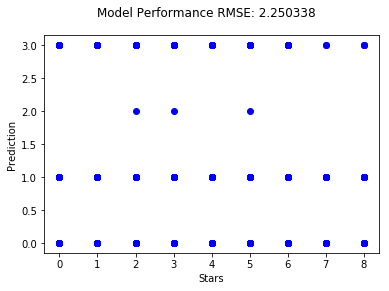

In [156]:
import matplotlib.pyplot as plt
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rfPred = cvModel.transform(lrData)
rfResult = rfPred.toPandas()
plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Stars')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

In [157]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.3100138531565407
0.2251087032065377


In [158]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline

Text(0.5,1,'Feature Importances')

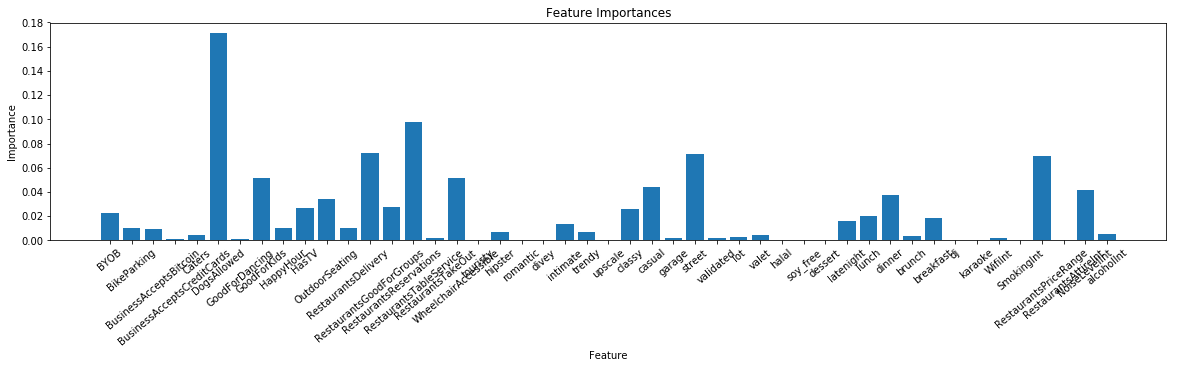

In [159]:
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.figure(figsize=(20,4))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [160]:
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

numTrees -  15
maxDepth -  5


### Logistic regression on review data

In [161]:
df_rev.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [ ]:
df_rev.count()

In [ ]:
df_rev_clean=df_rev.select("stars","text").dropna()

In [ ]:
df_rev_clean.count()

In [ ]:
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import unix_timestamp
#df2=df1.withColumn("date", unix_timestamp('date','MM/dd/yyyy').cast('timestamp'))
df_rev=df_rev.withColumn("date", unix_timestamp('date','yyyy-MM-dd HH:mm:ss').cast('timestamp'))

In [ ]:
%%time
from pyspark.sql.functions import month, year
df_rev = df_rev.withColumn('Year', year(df_rev['date']))
df_rev = df_rev.withColumn('Month', month(df_rev['date']))

In [ ]:
df_rev.printSchema()

In [ ]:
###
rev_time = df_rev.groupBy('Year', 'Month').count().orderBy(["Year", "Month"], ascending=[1, 1]).dropna()
p_rev_time = rev_time.toPandas()
p_rev_time.plot(y="count", figsize=(15,4), style="-")

In [ ]:
p_df = p_rev_time.pivot(index='Month', columns='Year', values='count')
p_df

In [ ]:
p_df.plot(figsize=(12,6))

In [ ]:
#import sparknlp
#sparknlp.start()

#from sparknlp.base import *
#from sparknlp.annotator import *
#from sparknlp.pretrained import PretrainedPipeline


In [ ]:
# Import modules
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import sh
%matplotlib inline

In [ ]:
#Maps a sequence of terms to their term frequencies using the hashing trick. 
indexer = StringIndexer(inputCol="stars", outputCol="label")
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=20)
idf = IDF(inputCol="rawFeatures", outputCol="features")


#A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow
pipeline = Pipeline(stages=[indexer,tokenizer, remover,hashingTF,idf])
lr_df = pipeline.fit(df_rev).transform(df_rev)
lr_df.select("label", "features").show(5, truncate=False)

In [ ]:
train_df, test_df = lr_df.randomSplit([.8,.2],seed=1234)
train_df.show(10, truncate = True)

In [ ]:
from pyspark.ml.classification import LogisticRegression
# set parameters for logistic regression
lgr = LogisticRegression(maxIter=20,featuresCol='features',labelCol='label')

#fit the model to the data
lgrmh = lgr.fit(train_df)

#given a dataset, predict each point's label, and show the results
predictions = lgrmh.transform(test_df)

In [ ]:
#evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

In [ ]:
lr_df.select('filtered').show(truncate=False)